# COLETA DE DADOS

In [1]:
!pip install kagglehub
!pip install scipy

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

import kagglehub
DATASET_PATH = os.environ.get("DATASET_PATH") or kagglehub.dataset_download(
    'hkayan/industrial-robotic-arm-imu-data-casper-1-and-2') + '/'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using Colab cache for faster access to the 'industrial-robotic-arm-imu-data-casper-1-and-2' dataset.
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_Acc_Gyro_20Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_hitting_arm.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_20Hz_freq_drop_2.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_hitting_platform.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_10Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/right_arm.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_2Hz.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/quaternions_no_idle.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_extra_weigth.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/IMU_20Hz_freq_drop.csv
/kaggle/input/industrial-robotic-arm-imu-data-casper-1-and-2/quaternions_20Hz.csv
/kaggle/

In [3]:
def split_sequencial(df, p_train=0.7, p_val=0.1, p_test=0.2):
    """Corta um DataFrame em 3 pedaços sequenciais baseados nas porcentagens."""
    size = len(df)
    end_train = int(size * p_train)
    end_val = int(size * (p_train + p_val))

    train = df.iloc[:end_train].copy()
    val = df.iloc[end_train:end_val].copy()
    test = df.iloc[end_val:].copy()

    return train, val, test

In [4]:
def split_train_val_test(df_normal,lista_df_falhas):
  norm_train, norm_val, norm_test = split_sequencial(df_normal)
  # Listas para acumular os pedaços (começamos com o normal)
  final_train_list = [norm_train]
  final_val_list   = [norm_val]
  final_test_list  = [norm_test]

  print(f"1. Normal processado: {len(df_normal)} linhas divididas.")

  for df_falhas in lista_df_falhas:
    f_train, f_val, f_test = split_sequencial(df_falhas,0,0.5,0.5)
    print(f"Falha {df_falhas.iloc[0]['scenario']} processado" )
    final_val_list.append(f_val)
    final_test_list.append(f_test)

  df_train_final = pd.concat(final_train_list, ignore_index=True)
  df_val_final = pd.concat(final_val_list, ignore_index=True)
  df_test_final = pd.concat(final_test_list, ignore_index=True)

  return df_train_final, df_val_final, df_test_final


In [5]:
import pandas as pd

print("--- CARREGAMENTO MANUAL DE CENÁRIOS ---")

# 1. Carregar o NORMAL (df)
# ------------------------------------------------------------------
print("Lendo Base Normal...")
df = pd.read_csv(DATASET_PATH + 'IMU_10Hz.csv')
df['label'] = 0
df['scenario'] = 'Normal'

# 2. Carregar AS ANOMALIAS (faultydf)
# ------------------------------------------------------------------
print("Lendo Base de Falhas...")

# Lista simples e direta com TODOS os arquivos de problema disponíveis
arquivos_falha = [
    'IMU_hitting_platform.csv',   # Colisão: Plataforma
    'IMU_hitting_arm.csv',        # Colisão: Braço (Robô se batendo)
    'IMU_extra_weigth.csv',       # Mecânico: Peso Extra (Esforço)
    'IMU_earthquake.csv',         # Ambiental: Terremoto (Vibração externa)
]

lista_dfs = []

for arquivo in arquivos_falha:
    # Carrega cada um individualmente
    temp_df = pd.read_csv(DATASET_PATH + arquivo)

    # Padroniza
    temp_df['label'] = 1             # Todo mundo aqui é erro
    temp_df['scenario'] = arquivo    # Guarda o nome pra você saber o que é

    lista_dfs.append(temp_df)
    print(f"-> Adicionado: {arquivo} ({len(temp_df)} linhas)")


df, df_val, df_test = split_train_val_test(df,lista_dfs)
print(len(df))
print(len(df_val))
print(len(df_test))

faultydf = df_val[df_val['label'] == 1].copy()

--- CARREGAMENTO MANUAL DE CENÁRIOS ---
Lendo Base Normal...
Lendo Base de Falhas...
-> Adicionado: IMU_hitting_platform.csv (14967 linhas)
-> Adicionado: IMU_hitting_arm.csv (11924 linhas)
-> Adicionado: IMU_extra_weigth.csv (10885 linhas)
-> Adicionado: IMU_earthquake.csv (11409 linhas)
1. Normal processado: 874937 linhas divididas.
Falha IMU_hitting_platform.csv processado
Falha IMU_hitting_arm.csv processado
Falha IMU_extra_weigth.csv processado
Falha IMU_earthquake.csv processado
612455
112085
199582


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. PREPARAÇÃO AUTOMÁTICA DOS DADOS
# ------------------------------------------------------------------------------
# Identificar colunas de sensores
cols_ignore = ['time', 'label', 'name', 'datetime', 'Unnamed: 0', 'scenario']
sensores = [c for c in df.columns if c not in cols_ignore]

print(f"Sensores detectados para análise: {sensores}")

df_total = pd.concat([df, df_val], ignore_index=True)

Sensores detectados para análise: ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']



4. ANÁLISE BIVARIADA ESTRATÉGICA (SOMENTE VARIÁVEIS PADRÃO)


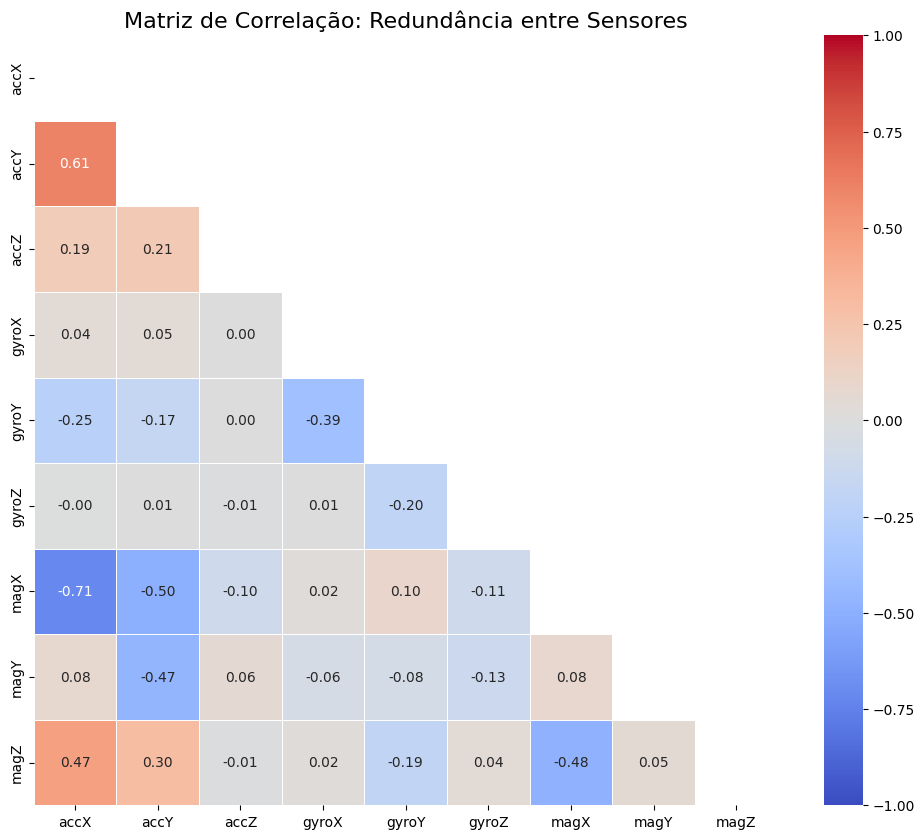


---> REDUNDÂNCIA #1 (Top 1 Feature-Feature)
     Par: accX vs magX (r=0.71)
     Motivo: O par de sensores brutos com maior vínculo físico.


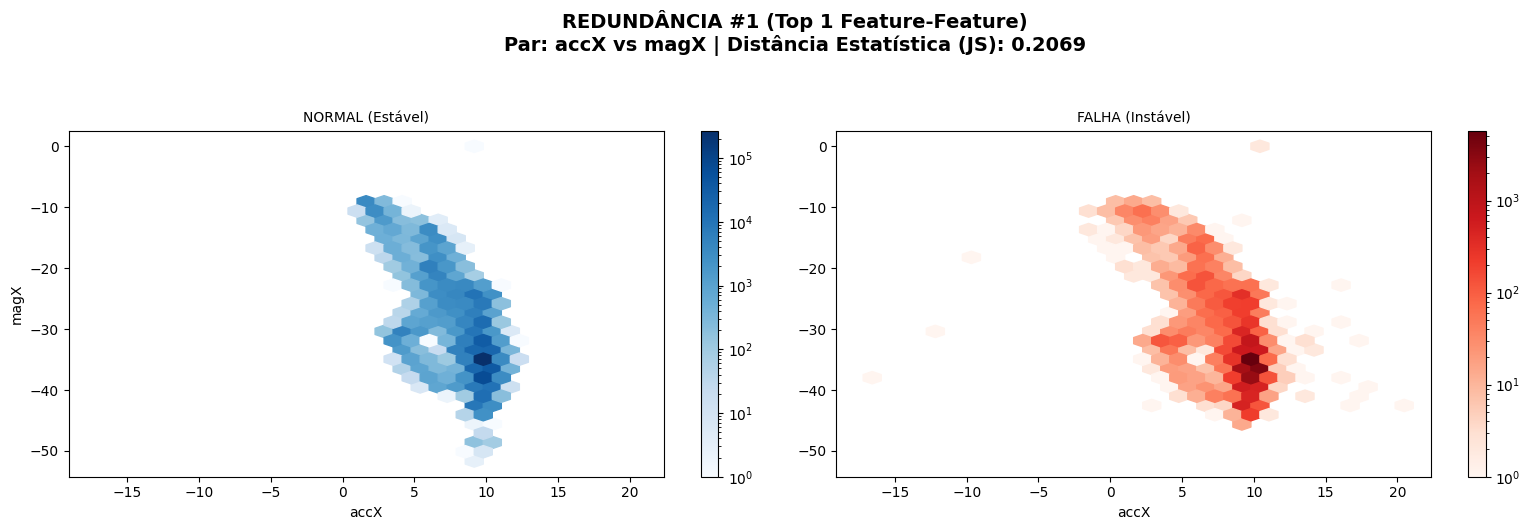


---> REDUNDÂNCIA #2 (Top 2 Feature-Feature)
     Par: accX vs accY (r=0.61)
     Motivo: Confirmação secundária de acoplamento mecânico.


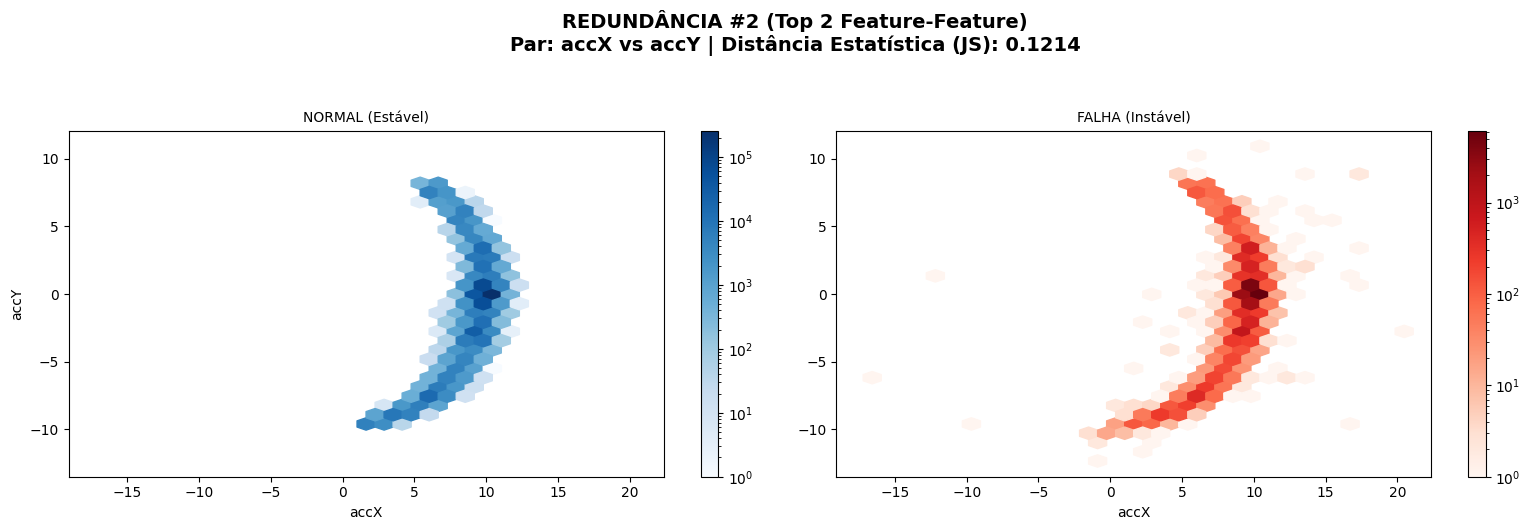


---> LINHA DE BASE (Média ~0.17)
     Par: accY vs gyroY (r=0.17)
     Motivo: Interação padrão entre eixos neste sistema.


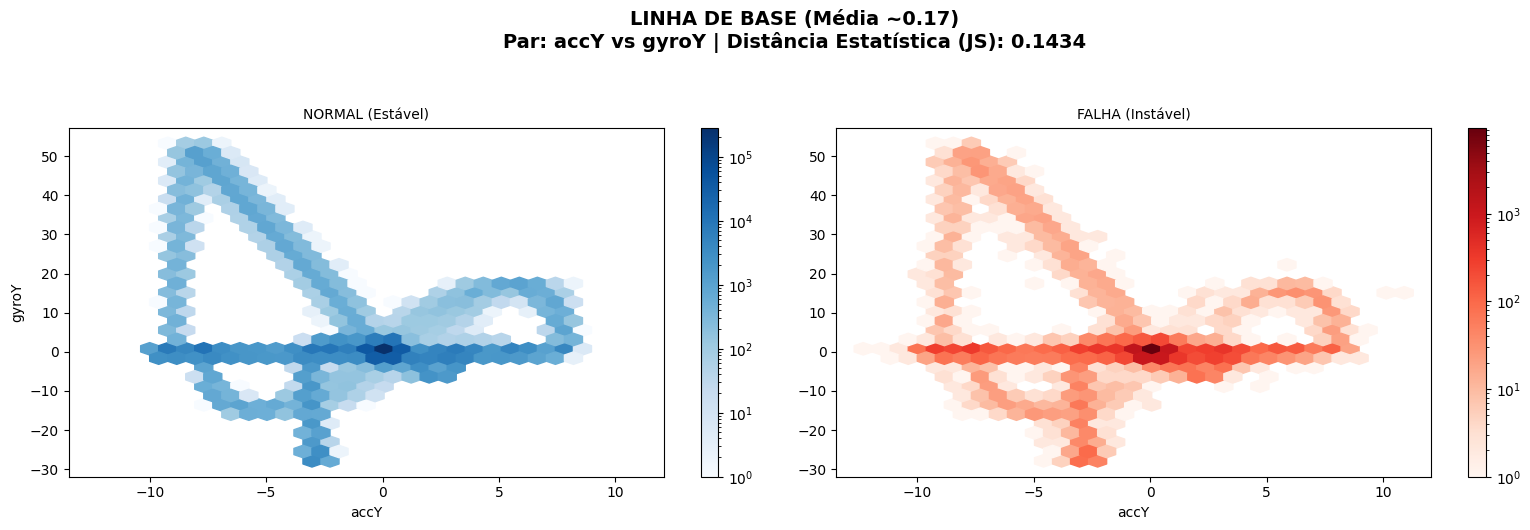


---> COMPLEMENTARIDADE (Informação Única)
     Par: accZ vs magZ (r=0.01)
     Motivo: Sensores importantes que "olham" aspectos diferentes da falha.


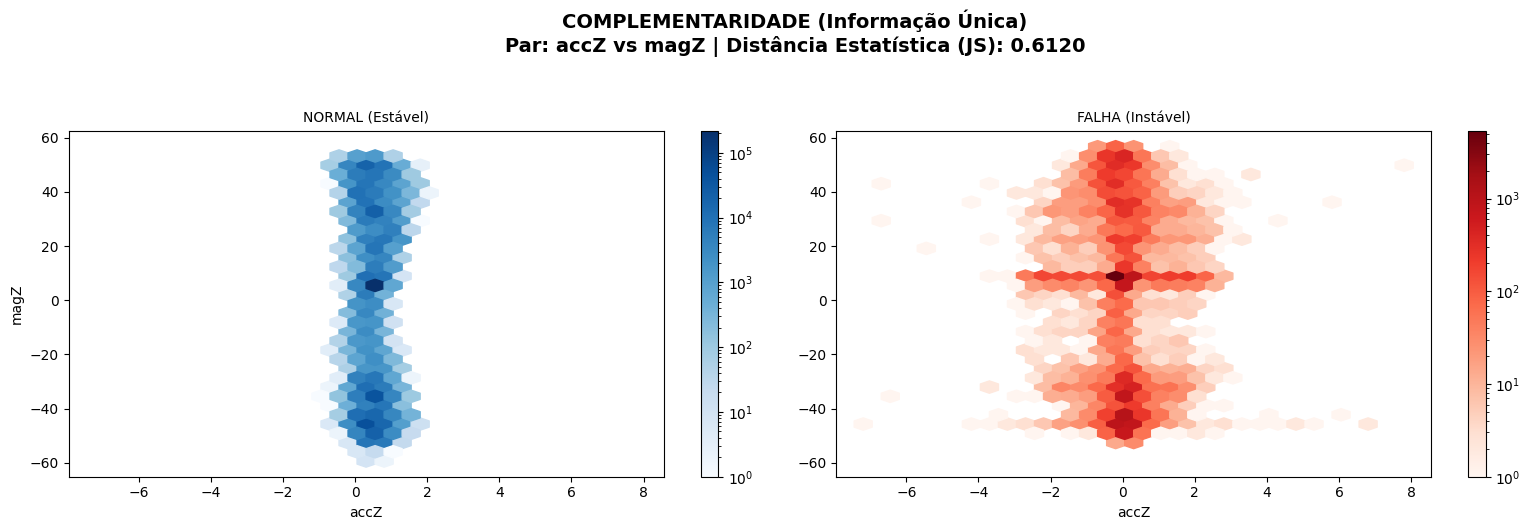


---> PODER PREDITIVO #1 (Top 1 vs Top 2)
     Par: accZ vs magX (r=0.10)
     Motivo: Os sensores campeões: accZ e magX.


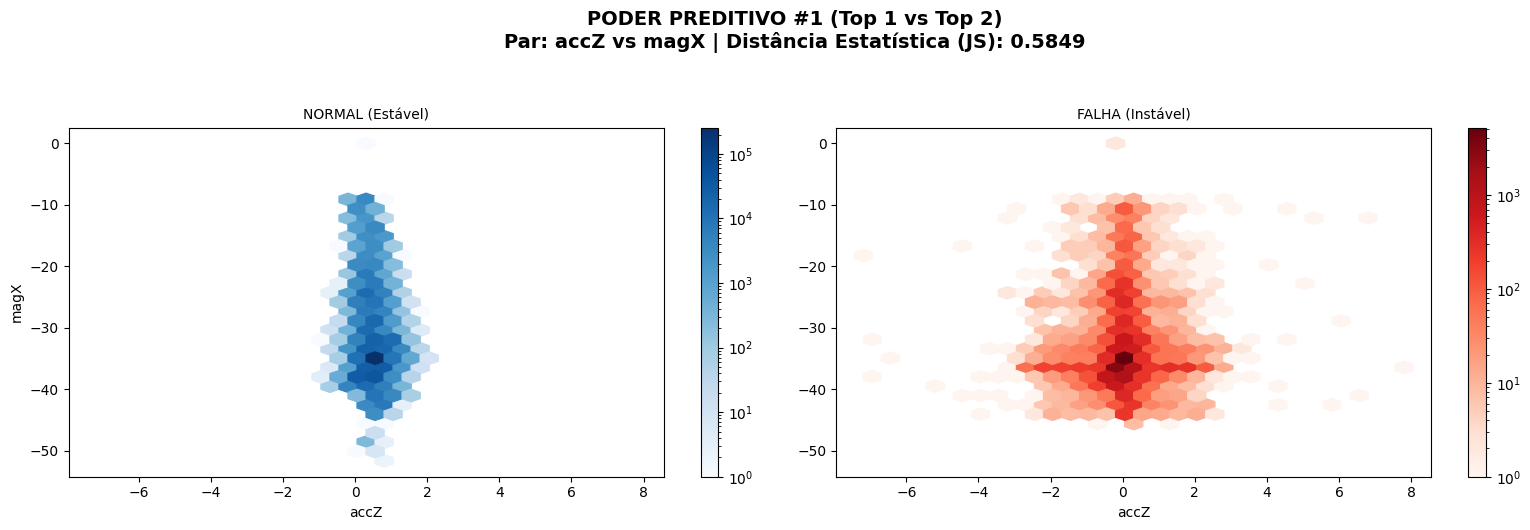


---> PODER PREDITIVO #2 (Top 3 vs Top 4)
     Par: magZ vs accY (r=0.30)
     Motivo: Sensores de suporte: magZ e accY.


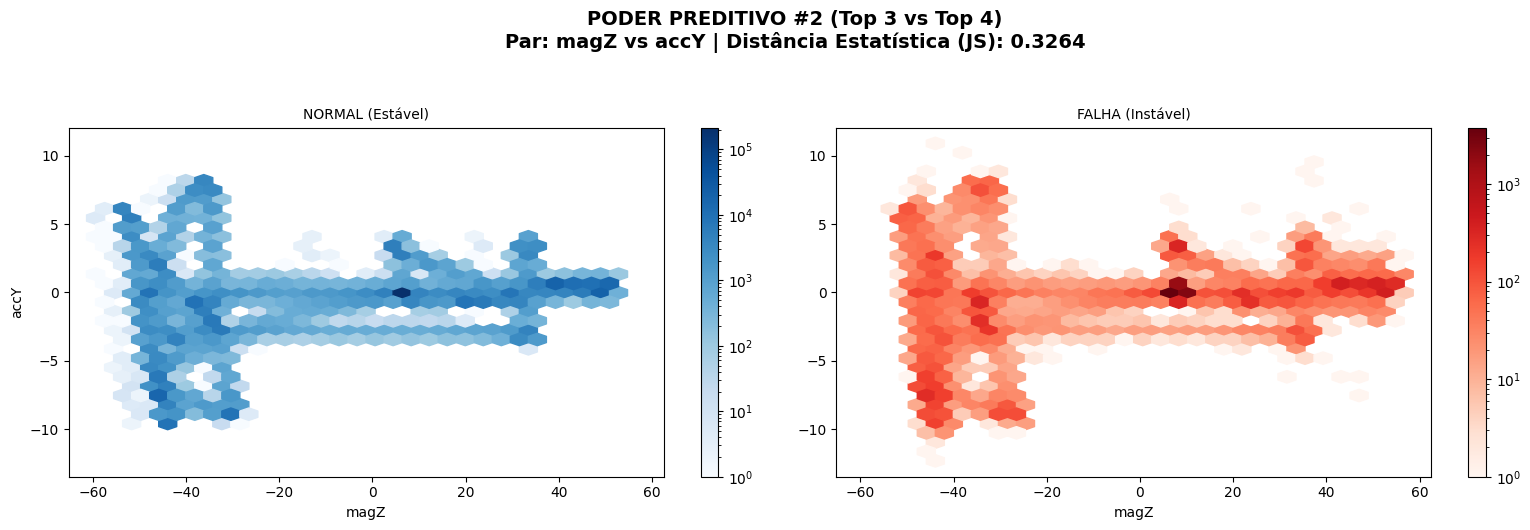

In [7]:
def analise_bivariada_estrategica_padrao(df_total):
    """
    Gera 6 cenários estratégicos para o relatório:
    1. REDUNDÂNCIA #1 (Maior Correlação Feature-Feature)
    2. REDUNDÂNCIA #2 (Segunda Maior Correlação - NOVO)
    3. MÉDIA (Correlação Típica/Mediana - NOVO)
    4. COMPLEMENTARIDADE (Baixa correlação entre features fortes)
    5. PREDITIVO #1 (Top 1 vs Top 2 Features com Label)
    6. PREDITIVO #2 (Top 3 vs Top 4 Features com Label - NOVO)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from scipy.spatial.distance import jensenshannon

    print("\n" + "="*80)
    print("4. ANÁLISE BIVARIADA ESTRATÉGICA (SOMENTE VARIÁVEIS PADRÃO)")
    print("="*80)

    # 1. DEFINIR APENAS OS SENSORES PADRÃO
    # Lista fixa dos 9 sensores possíveis
    lista_alvo = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'magX', 'magY', 'magZ']

    # Filtra para garantir que só usamos os que realmente existem no seu dataset
    sensores = [col for col in lista_alvo if col in df_total.columns]

    corr_m_1 = df_total[sensores].corr()
    plt.figure(figsize=(12, 10))
    # Máscara para esconder a metade repetida (triângulo superior)
    mask = np.triu(np.ones_like(corr_m_1, dtype=bool))

    sns.heatmap(corr_m_1, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                vmin=-1, vmax=1, center=0, linewidths=0.5)

    plt.title('Matriz de Correlação: Redundância entre Sensores', fontsize=16)
    plt.show()

    # --- 2. CÁLCULO DAS MATRIZES ---
    # Matriz de correlação apenas entre os sensores padrão
    corr_matrix = df_total[sensores].corr().abs()

    # Correlação com o Label (Poder Preditivo)
    corr_with_label = df_total[sensores + ['label']].corr()['label'].drop('label').abs().sort_values(ascending=False)
    top_features_label = corr_with_label.index.tolist()

    # Preparar lista de pares ordenados por correlação entre si
    all_pairs = []
    cols = corr_matrix.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            all_pairs.append({
                'par': (cols[i], cols[j]),
                'val': corr_matrix.iloc[i, j]
            })
    sorted_pairs = sorted(all_pairs, key=lambda x: x['val'], reverse=True)

    # --- 3. SELEÇÃO DOS 6 CENÁRIOS (Lógica Pura) ---
    cenarios = []

    # A. REDUNDÂNCIA #1 (Maior Correlação)
    cenarios.append({
        'titulo': 'REDUNDÂNCIA #1 (Top 1 Feature-Feature)',
        'par': sorted_pairs[0]['par'],
        'val': sorted_pairs[0]['val'],
        'desc': 'O par de sensores brutos com maior vínculo físico.'
    })

    # B. REDUNDÂNCIA #2 (Segunda Maior)
    cenarios.append({
        'titulo': 'REDUNDÂNCIA #2 (Top 2 Feature-Feature)',
        'par': sorted_pairs[1]['par'],
        'val': sorted_pairs[1]['val'],
        'desc': 'Confirmação secundária de acoplamento mecânico.'
    })

    # C. MÉDIA (Correlação Típica)
    mean_corr = np.mean([p['val'] for p in all_pairs])
    par_medio = min(all_pairs, key=lambda x: abs(x['val'] - mean_corr))
    cenarios.append({
        'titulo': f'LINHA DE BASE (Média ~{mean_corr:.2f})',
        'par': par_medio['par'],
        'val': par_medio['val'],
        'desc': 'Interação padrão entre eixos neste sistema.'
    })

    # D. COMPLEMENTARIDADE (Baixa Correlação entre os Melhores)
    # Pega os Top 5 sensores que melhor predizem a falha
    top5 = top_features_label[:5]
    best_pair_comp = None
    min_corr = 1.0

    # Acha qual par dentro desses Top 5 tem a MENOR correlação entre si
    for i in range(len(top5)):
        for j in range(i+1, len(top5)):
            c = corr_matrix.loc[top5[i], top5[j]]
            if c < min_corr:
                min_corr = c
                best_pair_comp = (top5[i], top5[j])

    cenarios.append({
        'titulo': 'COMPLEMENTARIDADE (Informação Única)',
        'par': best_pair_comp,
        'val': min_corr,
        'desc': 'Sensores importantes que "olham" aspectos diferentes da falha.'
    })

    # E. PODER PREDITIVO #1 (Top 1 vs Top 2 Impacto no Label)
    cenarios.append({
        'titulo': 'PODER PREDITIVO #1 (Top 1 vs Top 2)',
        'par': (top_features_label[0], top_features_label[1]),
        'val': corr_matrix.loc[top_features_label[0], top_features_label[1]],
        'desc': f'Os sensores campeões: {top_features_label[0]} e {top_features_label[1]}.'
    })

    # F. PODER PREDITIVO #2 (Top 3 vs Top 4 Impacto no Label)
    cenarios.append({
        'titulo': 'PODER PREDITIVO #2 (Top 3 vs Top 4)',
        'par': (top_features_label[2], top_features_label[3]),
        'val': corr_matrix.loc[top_features_label[2], top_features_label[3]],
        'desc': f'Sensores de suporte: {top_features_label[2]} e {top_features_label[3]}.'
    })

    # --- 4. PLOTAGEM ---
    for item in cenarios:
        sensor_a, sensor_b = item['par']
        print(f"\n---> {item['titulo']}")
        print(f"     Par: {sensor_a} vs {sensor_b} (r={item['val']:.2f})")
        print(f"     Motivo: {item['desc']}")

        data_normal_x = df_total[df_total['label']==0][sensor_a]
        data_normal_y = df_total[df_total['label']==0][sensor_b]
        data_fail_x = df_total[df_total['label']==1][sensor_a]
        data_fail_y = df_total[df_total['label']==1][sensor_b]

        # Limites e Bins
        min_x, max_x = min(data_normal_x.min(), data_fail_x.min()), max(data_normal_x.max(), data_fail_x.max())
        min_y, max_y = min(data_normal_y.min(), data_fail_y.min()), max(data_normal_y.max(), data_fail_y.max())
        grid_extent = (min_x, max_x, min_y, max_y)
        bins = 30
        range_limits = [[min_x, max_x], [min_y, max_y]]

        # Cálculo JS Distance
        hist_normal, _, _ = np.histogram2d(data_normal_x, data_normal_y, bins=bins, range=range_limits, density=True)
        hist_fail, _, _ = np.histogram2d(data_fail_x, data_fail_y, bins=bins, range=range_limits, density=True)
        p, q = hist_normal.flatten(), hist_fail.flatten()
        p, q = np.where(p==0, 1e-10, p), np.where(q==0, 1e-10, q)
        js_dist = jensenshannon(p, q)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))

        hb1 = axes[0].hexbin(data_normal_x, data_normal_y, gridsize=bins, cmap='Blues', bins='log', extent=grid_extent)
        axes[0].set_title(f'NORMAL (Estável)', fontsize=10)
        axes[0].set_xlabel(sensor_a); axes[0].set_ylabel(sensor_b)
        fig.colorbar(hb1, ax=axes[0])

        hb2 = axes[1].hexbin(data_fail_x, data_fail_y, gridsize=bins, cmap='Reds', bins='log', extent=grid_extent)
        axes[1].set_title(f'FALHA (Instável)', fontsize=10)
        axes[1].set_xlabel(sensor_a);
        fig.colorbar(hb2, ax=axes[1])

        plt.suptitle(f"{item['titulo']}\nPar: {sensor_a} vs {sensor_b} | Distância Estatística (JS): {js_dist:.4f}",
                     fontsize=14, fontweight='bold', y=1.05)
        plt.tight_layout()
        plt.show()

# EXECUÇÃO
analise_bivariada_estrategica_padrao(df_total)


5. ANÁLISE MULTIVARIADA (PCA) - VIZUALIZAÇÃO REFINADA


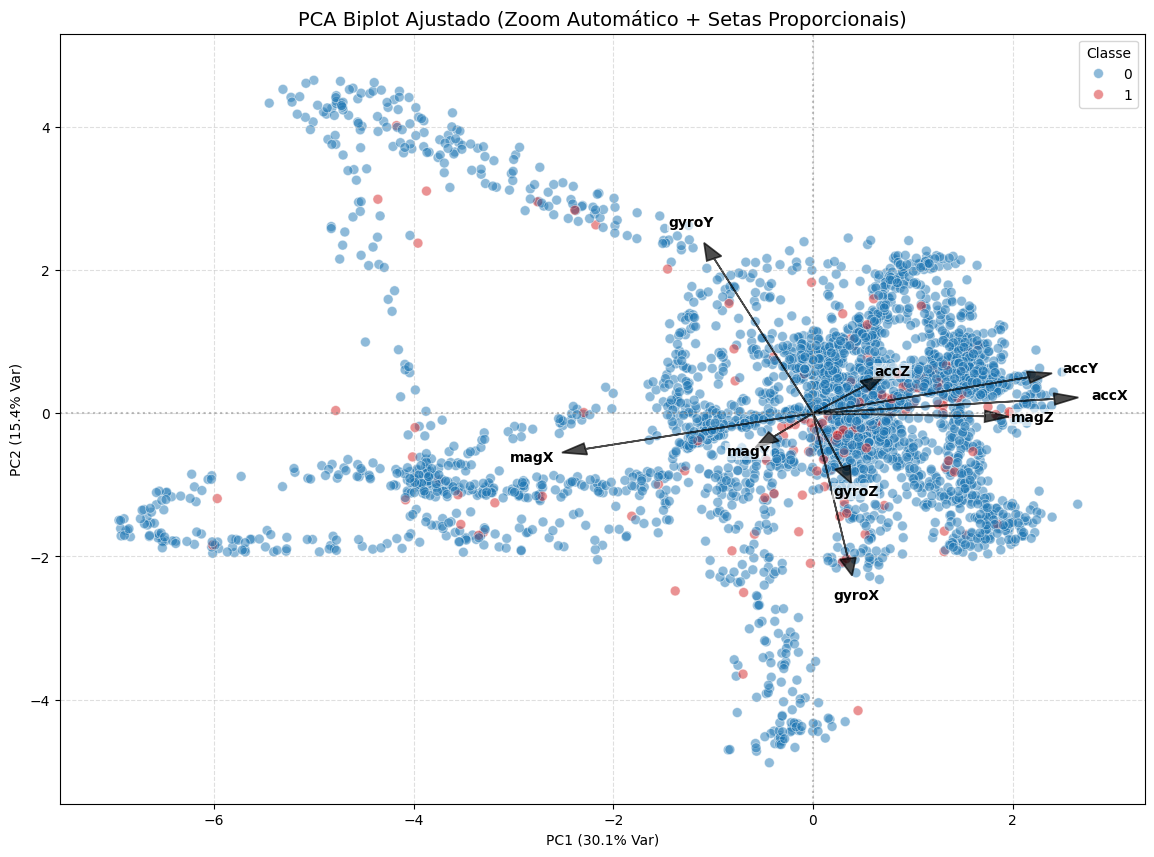

In [8]:
def analise_multivariada_pca_smart_zoom_v3(df_total, sensores):
    from sklearn.preprocessing import StandardScaler

    print("\n" + "="*80)
    print("5. ANÁLISE MULTIVARIADA (PCA) - VIZUALIZAÇÃO REFINADA")
    print("="*80)

    # 1. PREPARAÇÃO
    X = df_total[sensores]
    y = df_total['label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)

    df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    df_pca['label'] = y.values

    # 2. ZOOM INTELIGENTE
    # Ignora 1% dos extremos (outliers magnéticos)
    x_q01, x_q99 = df_pca['PC1'].quantile([0.01, 0.99])
    y_q01, y_q99 = df_pca['PC2'].quantile([0.01, 0.99])

    # Margem de 15%
    margin_x = (x_q99 - x_q01) * 0.15
    margin_y = (y_q99 - y_q01) * 0.15

    xlim = (x_q01 - margin_x, x_q99 + margin_x)
    ylim = (y_q01 - margin_y, y_q99 + margin_y)

    # 3. CÁLCULO DE ESCALA DAS SETAS (Para não saírem do gráfico)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    fatores_escala = []
    for i in range(len(loadings)):
        lx, ly = loadings[i, 0], loadings[i, 1]

        if lx > 0:   fator_x = xlim[1] / lx
        elif lx < 0: fator_x = xlim[0] / lx
        else:        fator_x = float('inf')

        if ly > 0:   fator_y = ylim[1] / ly
        elif ly < 0: fator_y = ylim[0] / ly
        else:        fator_y = float('inf')

        fatores_escala.append(abs(fator_x))
        fatores_escala.append(abs(fator_y))

    # Usa 80% do espaço disponível para garantir que o texto caiba
    scale_factor = min(fatores_escala) * 0.80

    # 4. PLOTAGEM
    plt.figure(figsize=(14, 10))

    idx_sample = np.random.choice(len(df_pca), size=min(5000, len(df_pca)), replace=False)
    sample = df_pca.iloc[idx_sample]

    sns.scatterplot(data=sample, x='PC1', y='PC2', hue='label',
                    palette={0: '#1f77b4', 1: '#d62728'}, alpha=0.5, s=50)

    # --- AJUSTE FINO DA CABEÇA DA SETA ---
    # Calcula o tamanho baseado na área visível do gráfico (1.5% do tamanho total)
    span_x = xlim[1] - xlim[0]
    span_y = ylim[1] - ylim[0]
    grafico_size = min(span_x, span_y)

    head_width_calc = grafico_size * 0.015  # 1.5% da largura do gráfico (bem sutil)
    head_length_calc = head_width_calc * 1.5 # Comprimento proporcional

    for i, sensor in enumerate(sensores):
        # Só desenha se tiver relevância mínima
        if abs(loadings[i, 0]) > 0.05 or abs(loadings[i, 1]) > 0.05:
            x_end = loadings[i, 0] * scale_factor
            y_end = loadings[i, 1] * scale_factor

            # Desenha a seta
            plt.arrow(0, 0, x_end, y_end,
                      color='black', alpha=0.7,
                      head_width=head_width_calc,
                      head_length=head_length_calc,
                      linewidth=1.2, length_includes_head=True)

            # Texto deslocado para longe da ponta (* 1.12 para afastar)
            # Adicionei um fundo branco semitransparente (bbox) para leitura perfeita
            plt.text(x_end * 1.12, y_end * 1.12,
                     sensor, color='black', ha='center', va='center',
                     fontweight='bold', fontsize=10,
                     bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.axhline(0, color='gray', linestyle=':', alpha=0.5)
    plt.axvline(0, color='gray', linestyle=':', alpha=0.5)

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Var)')
    plt.title(f'PCA Biplot Ajustado (Zoom Automático + Setas Proporcionais)', fontsize=14)
    plt.legend(title='Classe', loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

# EXECUÇÃO
analise_multivariada_pca_smart_zoom_v3(df_total, sensores)

1. Calibrando Espaço Visual Global (Régua Única)...
24591
-> Limites definidos: X=(-7.001636884076103, 2.8765286125045226), Y=(-5.2199441991300155, 4.740077311801933)
-> Processando: None | Quantidade de Amostras: 612455
-> Processando: IMU_hitting_platform.csv | Quantidade de Amostras: 7483
-> Processando: IMU_hitting_arm.csv | Quantidade de Amostras: 5962
-> Processando: IMU_extra_weigth.csv | Quantidade de Amostras: 5442
-> Processando: IMU_earthquake.csv | Quantidade de Amostras: 5704


/tmp/ipython-input-2554593462.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.94])


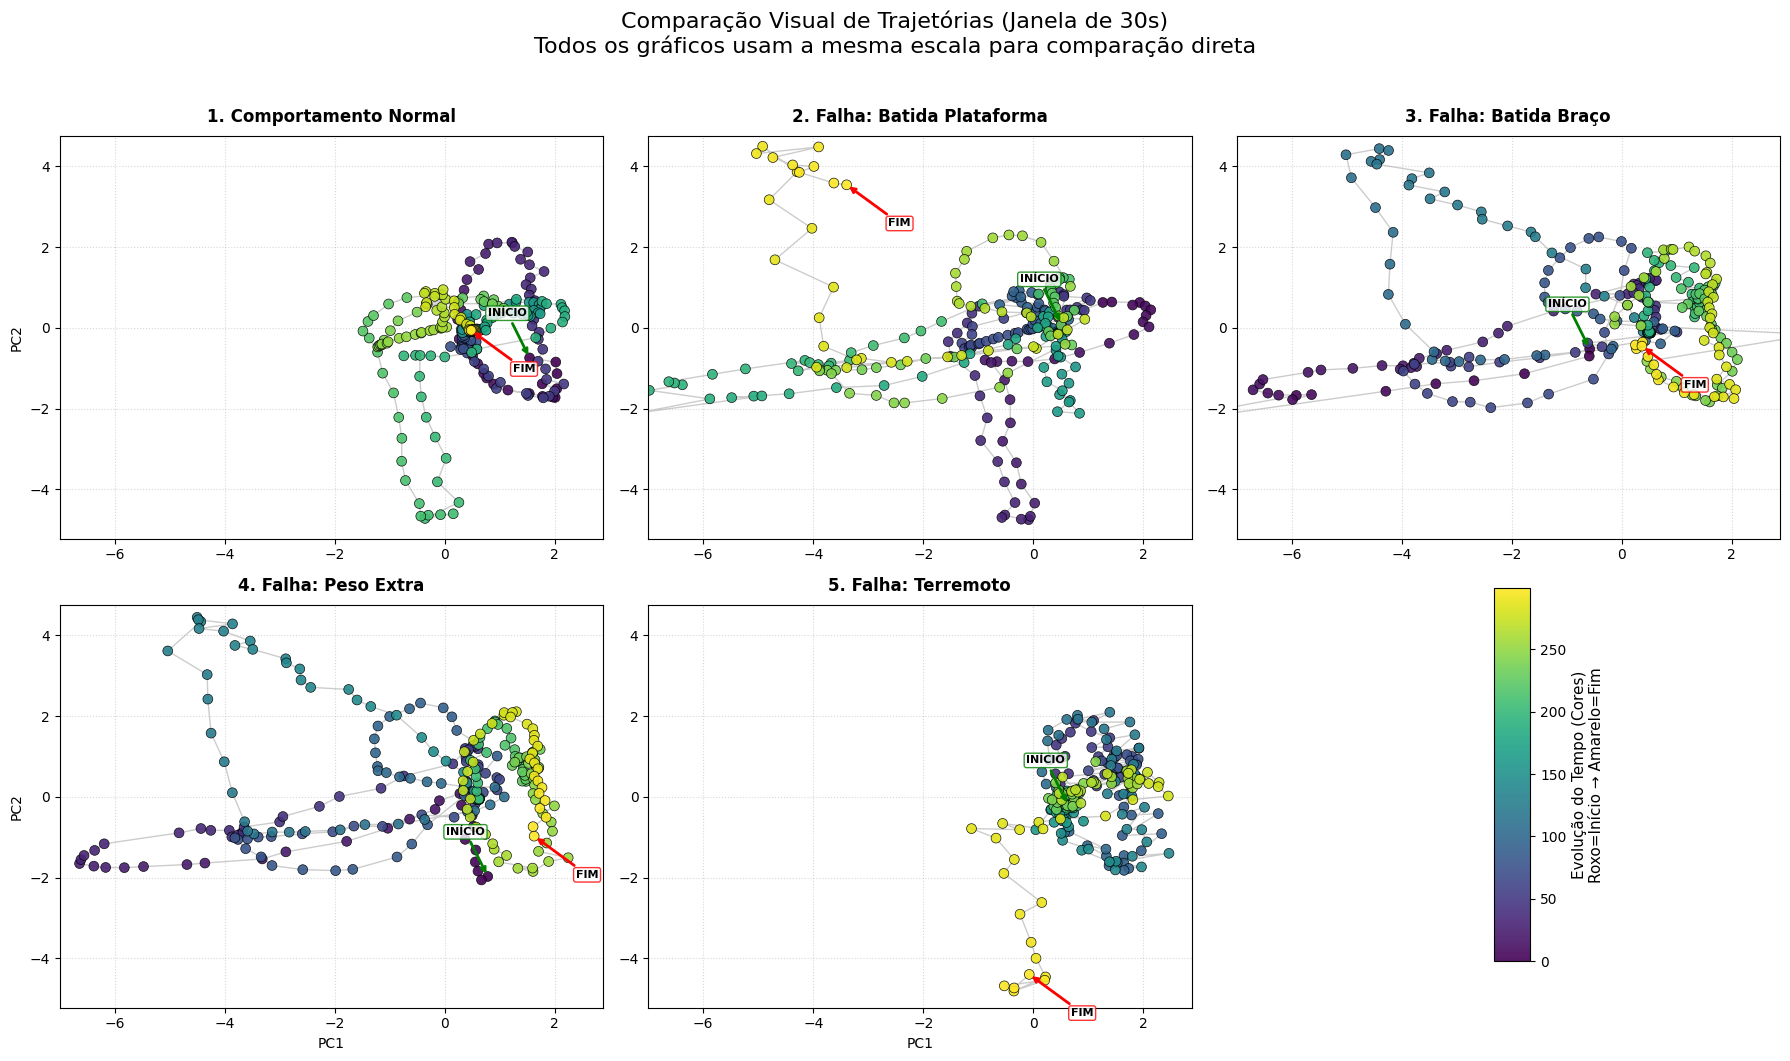

In [9]:
def visualizar_trajetorias_comparativas_regua_fixa(df_normal, df_falha, sensores, janela_segundos=10):
    """
    Gera um painel comparando o comportamento Normal com os 4 tipos de falha.
    Usa UMA RÉGUA VISUAL FIXA (limites X e Y iguais) para comparação justa.
    """

    print("1. Calibrando Espaço Visual Global (Régua Única)...")
    print(len(df_falha))

    # Juntamos tudo para definir a escala universal
    # Isso impede que o PCA se adapte a cada erro individualmente
    amostra_global = pd.concat([
        df_normal[sensores].sample(min(20000, len(df_normal))),
        df_falha[sensores].sample(min(20000, len(df_falha)))
    ])

    scaler = StandardScaler()
    pca = PCA(n_components=2)

    # Aprende a "régua" com todos os dados misturados
    X_global = scaler.fit_transform(amostra_global)
    coords_global = pca.fit_transform(X_global)

    # --- CÁLCULO DOS LIMITES GLOBAIS (ZOOM INTELIGENTE) ---
    # Ignoramos outliers extremos (1%) para focar onde a ação acontece
    df_coords = pd.DataFrame(coords_global, columns=['PC1', 'PC2'])

    x_min, x_max = df_coords['PC1'].quantile([0.01, 0.99])
    y_min, y_max = df_coords['PC2'].quantile([0.01, 0.99])

    # Adiciona margem de 10%
    margem_x = (x_max - x_min) * 0.1
    margem_y = (y_max - y_min) * 0.1

    xlim_global = (x_min - margem_x, x_max + margem_x)
    ylim_global = (y_min - margem_y, y_max + margem_y)

    print(f"-> Limites definidos: X={xlim_global}, Y={ylim_global}")

    # 2. Definição dos Cenários
    cenarios = [
        ("1. Comportamento Normal", df_normal, None),
        ("2. Falha: Batida Plataforma", df_falha, 'IMU_hitting_platform.csv'),
        ("3. Falha: Batida Braço", df_falha, 'IMU_hitting_arm.csv'),
        ("4. Falha: Peso Extra", df_falha, 'IMU_extra_weigth.csv'),
        ("5. Falha: Terremoto", df_falha, 'IMU_earthquake.csv')
    ]

    # 3. Criação dos Gráficos (Grid 2x3 para caber 5 gráficos)
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    lista_ax = axes.flatten()

    freq_hz = 10
    pontos_janela = janela_segundos * freq_hz

    for i, (titulo, df_fonte, nome_arquivo) in enumerate(cenarios):
        ax = lista_ax[i]

        # Filtro de dados
        if nome_arquivo:
            dados = df_fonte[df_fonte['scenario'] == nome_arquivo].copy()
        else:
            dados = df_fonte.copy()
        print(f"-> Processando: {nome_arquivo} | Quantidade de Amostras: {len(dados)}")
        # Se não tiver dados para esse cenário (ex: arquivo faltando), pula
        if len(dados) == 0:
            ax.text(0.5, 0.5, "Arquivo Não Encontrado", ha='center', fontsize=12, color='red')
            ax.set_title(titulo, color='gray')
            ax.axis('off')
            continue

        # Transforma para o espaço 2D GLOBAL
        coords = pca.transform(scaler.transform(dados[sensores]))
        df_pca = pd.DataFrame(coords, columns=['PC1', 'PC2'])

        # Recorte Temporal (Pega o meio para garantir movimento)
        meio = len(df_pca) // 2
        inicio = max(0, meio)
        fim = min(len(df_pca), meio + pontos_janela)

        # Se o trecho for muito curto, pega do início
        if (fim - inicio) < 10:
            inicio = 0
            fim = min(len(df_pca), pontos_janela)

        traj = df_pca.iloc[inicio : fim].reset_index(drop=True)

        # --- Desenho ---
        if len(traj) > 0:
            # Rastro cinza
            ax.plot(traj['PC1'], traj['PC2'], c='gray', lw=1, alpha=0.4, zorder=1)

            sc_plot = ax.scatter(traj['PC1'], traj['PC2'], c=np.arange(len(traj)),
                           cmap='viridis', s=50, alpha=0.9, edgecolor='k', lw=0.5, zorder=2)

            # --- SETA DE INÍCIO ---
            ax.annotate('INÍCIO', xy=(traj.iloc[0]['PC1'], traj.iloc[0]['PC2']),
                        xytext=(-30, 30), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", lw=2, color='green'),
                        fontsize=8, fontweight='bold', bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="green", alpha=0.8))

            # --- SETA DE FIM ---
            ax.annotate('FIM', xy=(traj.iloc[-1]['PC1'], traj.iloc[-1]['PC2']),
                        xytext=(30, -30), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", lw=2, color='red'),
                        fontsize=8, fontweight='bold', bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.8))

        # --- APLICANDO A RÉGUA FIXA ---
        ax.set_xlim(xlim_global)
        ax.set_ylim(ylim_global)

        ax.set_title(titulo, fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, linestyle=':', alpha=0.5)

        # Só coloca labels nos gráficos da borda esquerda/inferior para limpar o visual
        if i in [0, 3]: ax.set_ylabel("PC2")
        if i in [3, 4, 5]: ax.set_xlabel("PC1")

    # Desliga o último gráfico se sobrar (grid tem 6 espaços, usamos 5)
    if len(cenarios) < 6:
        lista_ax[-1].axis('off')

    plt.tight_layout()
    ax_legenda = lista_ax[-1]
    if sc_plot:
        # Pegamos a posição exata desse quadrado no grid [x, y, largura, altura]
        pos = ax_legenda.get_position()

        # Criamos um eixo novo DENTRO desse quadrado para ser a barra
        # Centralizado verticalmente e horizontalmente
        # Largura da barra = 5% do quadrado, Altura = 80% do quadrado
        cbar_width = 0.02
        cbar_height = pos.height * 0.8
        cbar_x = pos.x0 + (pos.width - cbar_width) / 2
        cbar_y = pos.y0 + (pos.height - cbar_height) / 2

        cbar_ax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])

        # Criamos a barra nesse eixo novo
        cbar = fig.colorbar(sc_plot, cax=cbar_ax)
        cbar.set_label('Evolução do Tempo (Cores)\nRoxo=Início → Amarelo=Fim', fontsize=11)


    plt.suptitle(f"Comparação Visual de Trajetórias (Janela de {janela_segundos}s)\nTodos os gráficos usam a mesma escala para comparação direta", fontsize=16, y=0.96)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

# EXECUÇÃO
visualizar_trajetorias_comparativas_regua_fixa(df, faultydf, sensores, janela_segundos=30)


CRIAÇÃO DE VARIÁVEIS DERIVADAS E GRUPOS DE INTERESSE
Calculando Magnitudes (Aceleração, Giroscópio e Magnetômetro)...


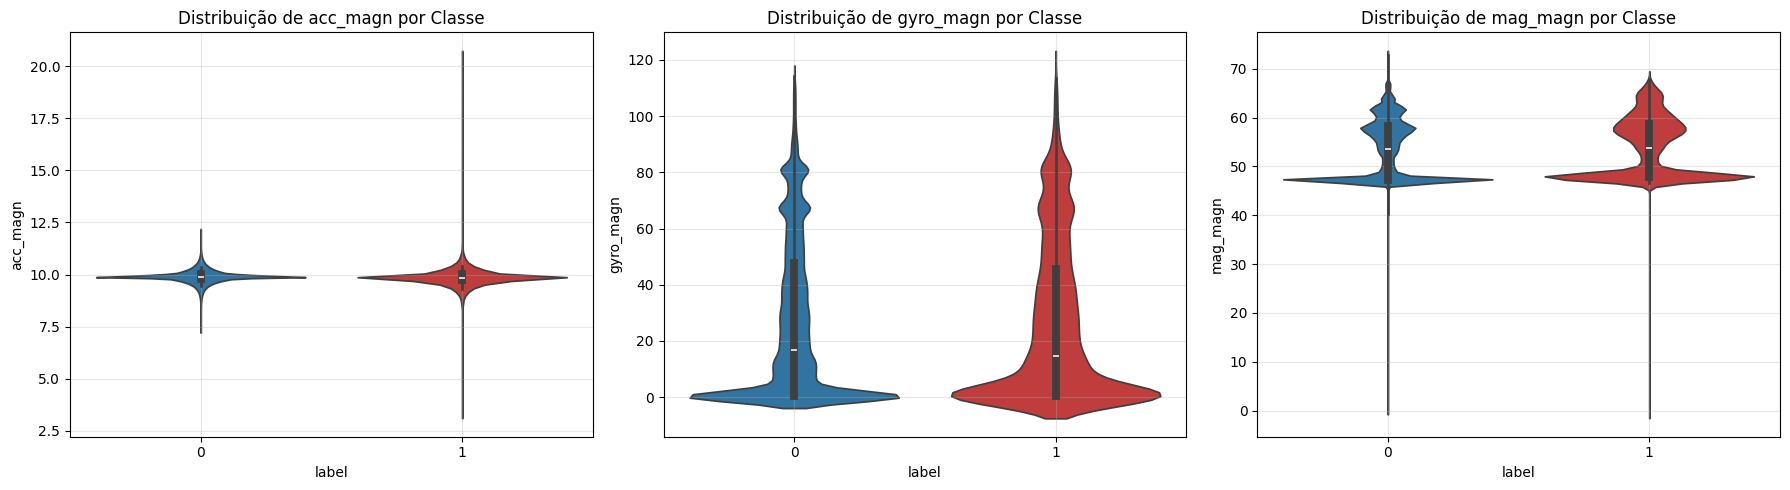


Executando K-Means para encontrar Grupos de Interesse...


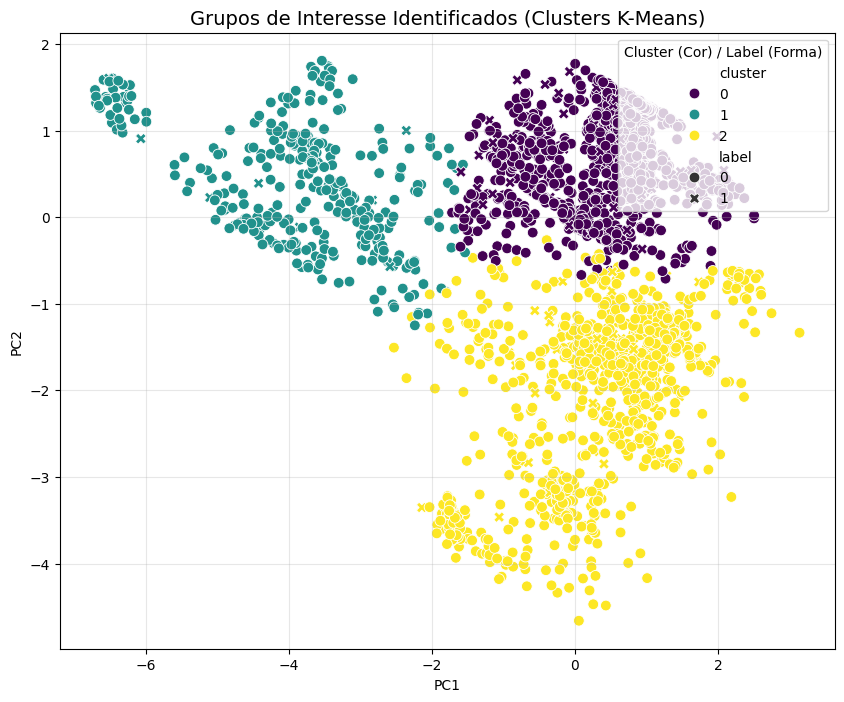


[INSIGHT] Distribuição de Falhas por Grupo Identificado:
label    Normal (%)  Falha (%)
cluster                       
0         96.601872   3.398128
1         96.528435   3.471565
2         96.646539   3.353461
--------------------------------------------------
-> ANÁLISE: Nenhum grupo se mostrou estatisticamente relevante.
-> O maior cluster (1) tem 3.47% de falhas, praticamente igual à média global (3.39%).
-> Isso indica que este método de agrupamento não conseguiu isolar a anomalia.


In [10]:
# ==============================================================================
# VARIÁVEIS DERIVADAS E ANÁLISE DE GRUPOS
# ==============================================================================
from sklearn.cluster import KMeans

def feature_engineering_e_cluster(df_total, sensores):
    print("\n" + "="*80)
    print("CRIAÇÃO DE VARIÁVEIS DERIVADAS E GRUPOS DE INTERESSE")
    print("="*80)

    # --- 1. CRIAÇÃO DE VARIÁVEIS DERIVADAS (Magnitude Física) ---
    print("Calculando Magnitudes (Aceleração, Giroscópio e Magnetômetro)...")

    # Magnitude da Aceleração
    df_total['acc_magn'] = np.sqrt(df_total['accX']**2 + df_total['accY']**2 + df_total['accZ']**2)

    # Magnitude do Giroscópio
    df_total['gyro_magn'] = np.sqrt(df_total['gyroX']**2 + df_total['gyroY']**2 + df_total['gyroZ']**2)

    df_total['mag_magn'] = np.sqrt(df_total['magX']**2 + df_total['magY']**2 + df_total['magZ']**2)

    novas_features = ['acc_magn', 'gyro_magn', 'mag_magn']
    n_plots = 3
    fig_width = 18

    # Visualizar (Violin Plot)
    plt.figure(figsize=(fig_width, 5))

    for i, feat in enumerate(novas_features):
        plt.subplot(1, n_plots, i+1)

        # Sintaxe atualizada para evitar warnings
        sns.violinplot(data=df_total, x='label', y=feat, hue='label',
                       palette={0: '#1f77b4', 1: '#d62728'}, legend=False)

        plt.title(f'Distribuição de {feat} por Classe')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2. ANÁLISE DE GRUPOS DE INTERESSE (CLUSTERING) ---
    print("\nExecutando K-Means para encontrar Grupos de Interesse...")

    features_cluster = sensores + novas_features

    # Padronizar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_total[features_cluster])

    # Criar 3 Clusters
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_total['cluster'] = kmeans.fit_predict(X_scaled)

    # Visualizar Clusters no Espaço PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(X_scaled)
    df_total['PC1'] = pca_coords[:, 0]
    df_total['PC2'] = pca_coords[:, 1]

    plt.figure(figsize=(10, 8))
    # Usamos style='label' para diferenciar visualmente quem é normal/falha dentro do cluster
    sns.scatterplot(data=df_total.sample(min(3000, len(df_total)), random_state=42),
                    x='PC1', y='PC2', hue='cluster', palette='viridis',
                    style='label', s=60)
    plt.title('Grupos de Interesse Identificados (Clusters K-Means)', fontsize=14)
    plt.legend(title='Cluster (Cor) / Label (Forma)', loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 3. ANÁLISE CRUZADA: CLUSTER vs FALHA ---
    tabela_grupos = pd.crosstab(df_total['cluster'], df_total['label'], normalize='index') * 100
    print("\n[INSIGHT] Distribuição de Falhas por Grupo Identificado:")
    print(tabela_grupos.rename(columns={0: 'Normal (%)', 1: 'Falha (%)'}))
    print("-" * 50)

    taxa_global = df_total['label'].mean() * 100

    # Pega o pior grupo
    grupo_risco = tabela_grupos[1].idxmax()
    risco_val = tabela_grupos.loc[grupo_risco, 1]

    # Define um limiar de relevância: O grupo tem que ser pelo menos 30% pior que a média global
    # Ex: Se média é 1.7%, o grupo tem que ter > 2.2% para ser "Interessante"
    limiar_relevancia = taxa_global * 1.3

    if risco_val > limiar_relevancia:
        print(f"-> O Grupo {grupo_risco} DESTACA-SE como 'Grupo de Interesse'.")
        print(f"-> Ele concentra {risco_val:.2f}% de falhas (Média Global: {taxa_global:.2f}%).")
    else:
        print(f"-> ANÁLISE: Nenhum grupo se mostrou estatisticamente relevante.")
        print(f"-> O maior cluster ({grupo_risco}) tem {risco_val:.2f}% de falhas, praticamente igual à média global ({taxa_global:.2f}%).")
        print(f"-> Isso indica que este método de agrupamento não conseguiu isolar a anomalia.")

# EXECUÇÃO
feature_engineering_e_cluster(df_total, sensores)

In [11]:
def gerar_tabela_ranking_ks(df_total, lista_sensores):
    """
    Gera uma tabela formatada de ranking de importância baseada no teste KS,
    Ratio de Variância e Diferença de Médias.
    """
    from scipy.stats import ks_2samp

    resultados = []

    for sensor in lista_sensores:
        # Garante que o sensor existe no dataframe
        if sensor not in df_total.columns:
            continue

        # Separa os dados (Limpando NaNs para evitar erros)
        data_normal = df_total[df_total['label'] == 0][sensor].dropna()
        data_falha = df_total[df_total['label'] == 1][sensor].dropna()

        # 1. KS Statistic (Poder de Separação)
        # Retorna a estatística KS (distância máxima entre as curvas acumuladas)
        ks_stat, _ = ks_2samp(data_normal, data_falha)

        # 2. Variance Ratio (Sensibilidade à Vibração)
        var_norm = np.var(data_normal)
        var_fail = np.var(data_falha)
        # Evita divisão por zero
        if var_norm == 0: var_norm = 1e-9
        var_ratio = var_fail / var_norm

        # 3. Mean Difference (Mudança de Ponto de Operação)
        mean_diff = abs(np.mean(data_falha) - np.mean(data_normal))

        resultados.append({
            'Sensor': sensor,
            'KS_Statistic': ks_stat,
            'Variance_Ratio': var_ratio,
            'Mean_Diff': mean_diff
        })

    # Cria o DataFrame e ordena pelo KS
    df_rank = pd.DataFrame(resultados)
    df_rank = df_rank.sort_values(by='KS_Statistic', ascending=False).reset_index(drop=True)

    # --- EXIBIÇÃO FORMATADA IGUAL AO SEU PEDIDO ---
    print("="*60)
    print("RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)")
    print("="*60)
    print("KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível")
    print("Variance_Ratio: > 1.0 = Falha aumentou a variabilidade")
    print("-" * 60)

    # Imprime a tabela alinhada
    print(df_rank.to_string(index=True, float_format="%.6f"))

    return df_rank

# EXECUÇÃO
variaveis_para_teste = sensores + ['acc_magn', 'gyro_magn','mag_magn']

# Filtra apenas as que existem no seu DF para não dar erro
variaveis_existentes = [v for v in variaveis_para_teste if v in df_total.columns]

tabela = gerar_tabela_ranking_ks(df_total, variaveis_existentes)

RANKING DE IMPORTÂNCIA DOS SENSORES (Baseado em KS-Test)
KS_Statistic: 1.0 = Separação Perfeita | 0.0 = Indistinguível
Variance_Ratio: > 1.0 = Falha aumentou a variabilidade
------------------------------------------------------------
       Sensor  KS_Statistic  Variance_Ratio  Mean_Diff
0        accZ      0.670706        7.667579   0.469562
1        magZ      0.294999        0.994203   1.790086
2    mag_magn      0.289964        1.011573   0.385666
3    acc_magn      0.229050        1.838561   0.043804
4        accX      0.216205        1.039565   0.045101
5        magX      0.188375        0.944100   0.703420
6        magY      0.153029        0.965325   0.520484
7        accY      0.109595        0.999446   0.129703
8       gyroX      0.064565        0.966838   0.041057
9   gyro_magn      0.046486        0.990408   0.905255
10      gyroZ      0.034084        0.962983   0.025204
11      gyroY      0.025615        0.938216   0.119778



ROUND 1: QUEM É O MELHOR SENSOR PURO? (Apenas os 9 eixos)


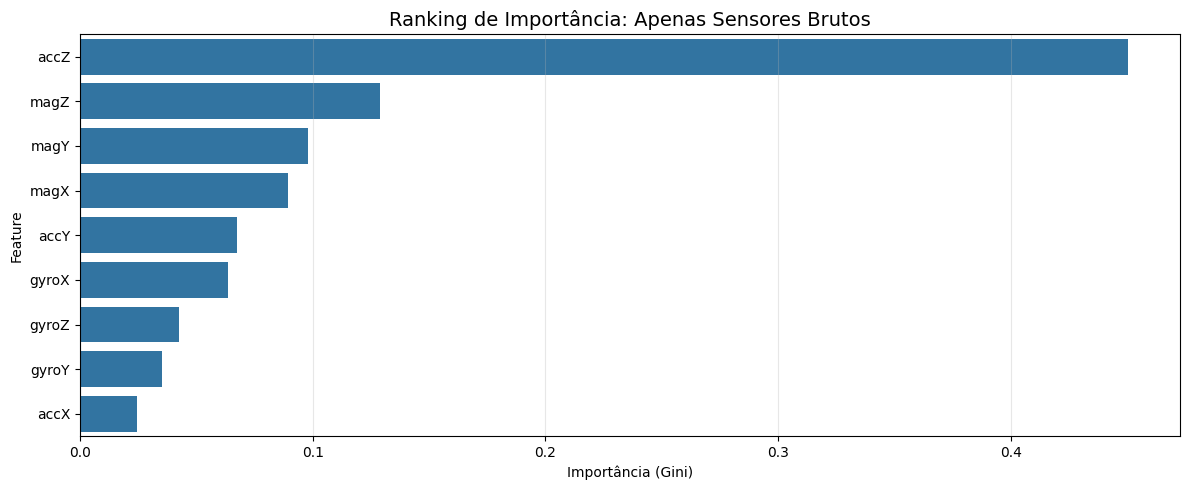


ROUND 2: DUELO GERAL (Sensores Brutos vs Variáveis Criadas)


/tmp/ipython-input-116096210.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=imp_full, palette=cores, alpha=0.8)


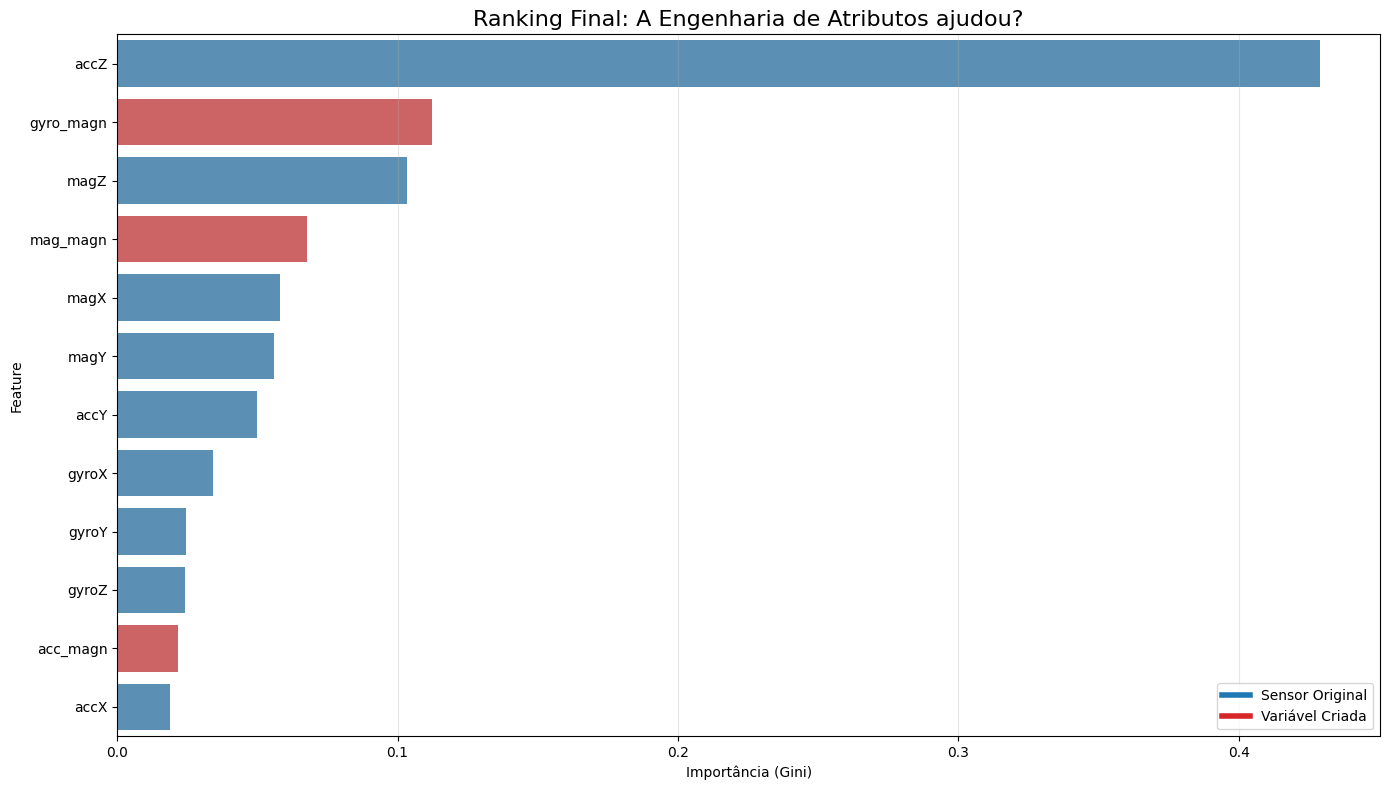

In [12]:
def ranking_de_importancia(df_total, sensores_originais):
    """
    Executa duas análises de importância via Random Forest:
    1. Apenas com os Sensores Originais (Quem é o melhor sensor físico?).
    2. Com Todas as Variáveis (A engenharia de atributos superou o dado bruto?).
    """
    from sklearn.ensemble import RandomForestClassifier

    # --- PREPARAÇÃO DE DADOS (Feito uma vez só para economizar RAM) ---
    # Usamos uma amostra de 20k linhas
    if len(df_total) > 20000:
        df_sample = df_total.sample(20000, random_state=42)
    else:
        df_sample = df_total.copy()

    y = df_sample['label']

    # Identificar variáveis derivadas
    palavras_chave = ['magn', 'std', 'mean', 'jerk', 'mad', 'energy', 'kurtosis']
    features_extras = [col for col in df_total.columns if any(p in col for p in palavras_chave)]
    # Garante que são numéricas
    features_extras = [f for f in features_extras if f in df_total.columns and df_total[f].dtype in [np.float64, np.float32, np.int64]]

    # ==========================================================================
    # ROUND 1: APENAS SENSORES ORIGINAIS (RAW DATA)
    # ==========================================================================
    print("\n" + "="*80)
    print("ROUND 1: QUEM É O MELHOR SENSOR PURO? (Apenas os 9 eixos)")
    print("="*80)

    # Filtra apenas colunas que existem no DF
    sensores_existentes = [s for s in sensores_originais if s in df_total.columns]

    model_raw = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    model_raw.fit(df_sample[sensores_existentes], y)

    imp_raw = pd.DataFrame({
        'Feature': sensores_existentes,
        'Importancia': model_raw.feature_importances_
    }).sort_values('Importancia', ascending=False)

    # Plot Round 1
    plt.figure(figsize=(12, 5))
    sns.barplot(x='Importancia', y='Feature', data=imp_raw, color='#1f77b4') # Tudo Azul
    plt.title('Ranking de Importância: Apenas Sensores Brutos', fontsize=14)
    plt.xlabel('Importância (Gini)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ==========================================================================
    # ROUND 2: DUELO COMPLETO (ORIGINAIS vs DERIVADAS)
    # ==========================================================================
    print("\n" + "="*80)
    print("ROUND 2: DUELO GERAL (Sensores Brutos vs Variáveis Criadas)")
    print("="*80)

    features_finais = list(set(sensores_existentes + features_extras))

    model_full = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    model_full.fit(df_sample[features_finais], y)

    imp_full = pd.DataFrame({
        'Feature': features_finais,
        'Importancia': model_full.feature_importances_
    }).sort_values('Importancia', ascending=False)

    # Plot Round 2
    plt.figure(figsize=(14, 8))
    # Cores: Azul (Original) vs Vermelho (Criada)
    cores = ['#1f77b4' if f in sensores_originais else '#d62728' for f in imp_full['Feature']]

    sns.barplot(x='Importancia', y='Feature', data=imp_full, palette=cores, alpha=0.8)

    # Legenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#1f77b4', lw=4, label='Sensor Original'),
        Line2D([0], [0], color='#d62728', lw=4, label='Variável Criada')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.title('Ranking Final: A Engenharia de Atributos ajudou?', fontsize=16)
    plt.xlabel('Importância (Gini)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# EXECUÇÃO
ranking_de_importancia(df_total, sensores)